<a href="https://colab.research.google.com/github/Tony5t4rk/ML-2021-Spring/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

作者: 刘阳

学习笔记：[機器學習2021 学习笔记-Introduction](https://www.wolai.com/tony5t4rk/9d8ktj9cGJb8BUafLhWPZ9)

本HW01是在[样例代码](https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb#scrollTo=ZeZnPAiwDRWG)的基础上进行修改完成的，代码中的修改部分使用注释`# Tony5t4rk:`进行标注。


# 挂载到Google Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab/ML 2021 Spring/HW01'

Mounted at /content/drive
/content/drive/MyDrive/Colab/ML 2021 Spring/HW01


# 查看当前设备GPU

In [6]:
!nvidia-smi

Fri Apr 30 09:33:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 从Google Drive下载数据

In [7]:
train_file = 'covid.train.csv'
test_file = 'covid.test.csv'

!gdown --id '1jpx8a0aXhz1RPirdCtX5rZGVtaDdNSkx' --output covid.train.csv
!gdown --id '1Itr_zqKBNbK75LAUTkUo00L9J1aVfe6C' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=1jpx8a0aXhz1RPirdCtX5rZGVtaDdNSkx
To: /content/drive/MyDrive/Colab/ML 2021 Spring/HW01/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 64.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Itr_zqKBNbK75LAUTkUo00L9J1aVfe6C
To: /content/drive/My Drive/Colab/ML 2021 Spring/HW01/covid.test.csv
100% 651k/651k [00:00<00:00, 93.0MB/s]


# 导入需要使用的模块

In [8]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 数据预处理
import numpy as np
import csv
import os

# 绘图
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# 设置随机数种子（为了实验的可复现性）
my_seed = 42096
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# 定义画图工具函数

In [9]:
# 绘制深度神经网络学习曲线（训练和验证的Loss）
def plot_learning_curve(loss_record, title=''):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.savefig('Learning curve of {}.svg'.format(title))
    plt.show()

# 绘制DNN的验证预测结果
def plot_pred(dev_dataloader, model, device, lim=35., preds=None, targets=None):
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dev_dataloader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()
    
    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.title('Ground Truth v.s. Best Model Prediction')
    plt.savefig('Ground Truth v.s. Best Model Prediction.svg')
    plt.show()

# 预处理

## 数据集类

In [10]:
class COVID19_Dataset(Dataset):
    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode

        # 使用numpy数组的方式读取数据
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            feats = list(range(93))
        else:
            # Tony5t4rk: 40个特征 + 前2天的结果[57, 75]
            feats = list(range(40)) + [57, 75]
        
        if mode == 'test':
            # 测试数据 data: (893, len(feats))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # 训练数据（训练集和验证集） data: (2700, len(feats))
            target = data[:, -1]
            data = data[:, feats]

            # 拆分训练集为训练集和验证集
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # 换为PyTorch Tensor数据
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # 特征归一化
        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
    
    def __getitem__(self, index):
        if self.mode in ['train', 'dev']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]
    
    def __len__(self):
        return len(self.data)

## 数据迭代器

In [11]:
# 生成数据迭代器
def set_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    dataset = COVID19_Dataset(path, mode=mode, target_only=target_only)
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True
    )
    return dataloader

# 定义深度神经网络类

In [12]:
# 一个简单的全连接深度神经网络
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()

        # 定义神经网络
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # MSE LOSS
        self.criterion = nn.MSELoss(reduction='mean')
    
    def forward(self, x):
        # x: (batch_size, input_dim)
        return self.net(x).squeeze(1)
    
    def calc_loss(self, pred, target):
        # TODO: you may implement L1/L2 regularization here
        return self.criterion(pred, target)

# 训练 & 验证 & 测试

## 训练

In [13]:
# 训练深度神经网络
def train(train_dataloader, dev_dataloader, model, config, device):
    n_epochs = config['n_epochs']
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparams'])
    min_dev_mse_loss = float('inf')
    loss_record = {'train': [], 'dev': []}
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            mse_loss = model.calc_loss(pred, y)
            mse_loss.backward()
            optimizer.step()
            loss_record['train'].append(mse_loss.detach().cpu().item())
        
        dev_mse_loss = dev(dev_dataloader, model, device)
        if dev_mse_loss < min_dev_mse_loss:
            min_dev_mse_loss = dev_mse_loss
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_dev_mse_loss))
            torch.save(model, config['save_path'])
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
        
        epoch += 1
        loss_record['dev'].append(dev_mse_loss)
        if early_stop_cnt > config['early_stop']:
            break
    print('Finish train after {} epochs'.format(epoch))
    return min_dev_mse_loss, loss_record

## 验证

In [14]:
def dev(dev_dataloader, model, device):
    model.eval()
    total_loss = 0
    for x, y in dev_dataloader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            mse_loss = model.calc_loss(pred, y)
        total_loss += mse_loss.detach().cpu().item() * len(x)
    total_loss /= len(dev_dataloader.dataset)
    return total_loss

## 测试

In [15]:
def test(test_dataloader, model, device):
    model.eval()
    preds = []
    for x in test_dataloader:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    return preds

# 配置Hyper-parameters

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('models', exist_ok=True)
target_only = True

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 3000,
    'batch_size': 270,
    'optimizer': 'SGD',
    'optim_hparams': {
        'lr': 0.001,
        'momentum': 0.9
    },
    'early_stop': 200,
    'save_path': 'models/model.pth'
}

# 加载数据


In [17]:
train_dataloader = set_dataloader(train_file, 'train', config['batch_size'], target_only=target_only)
dev_dataloader = set_dataloader(train_file, 'dev', config['batch_size'], target_only=target_only)
test_dataloader = set_dataloader(test_file, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 42)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 42)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 42)


# 加载Model

In [18]:
model = Net(train_dataloader.dataset.dim).to(device)

# 开始训练

In [19]:
model_min_dev_loss, model_loss_record = train(train_dataloader, dev_dataloader, model, config, device)

Saving model (epoch =    1, loss = 259.8888)
Saving model (epoch =    2, loss = 26.3095)
Saving model (epoch =    3, loss = 20.3508)
Saving model (epoch =    5, loss = 4.0548)
Saving model (epoch =    6, loss = 2.0190)
Saving model (epoch =    9, loss = 1.5674)
Saving model (epoch =   10, loss = 1.3859)
Saving model (epoch =   11, loss = 1.3680)
Saving model (epoch =   12, loss = 1.3613)
Saving model (epoch =   13, loss = 1.3214)
Saving model (epoch =   14, loss = 1.3023)
Saving model (epoch =   15, loss = 1.2863)
Saving model (epoch =   16, loss = 1.2699)
Saving model (epoch =   17, loss = 1.2598)
Saving model (epoch =   18, loss = 1.2440)
Saving model (epoch =   19, loss = 1.2321)
Saving model (epoch =   20, loss = 1.2218)
Saving model (epoch =   21, loss = 1.2136)
Saving model (epoch =   22, loss = 1.2009)
Saving model (epoch =   23, loss = 1.1945)
Saving model (epoch =   24, loss = 1.1829)
Saving model (epoch =   25, loss = 1.1747)
Saving model (epoch =   26, loss = 1.1721)
Saving 

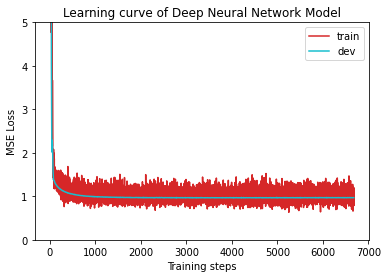

In [20]:
plot_learning_curve(model_loss_record, title='Deep Neural Network Model')

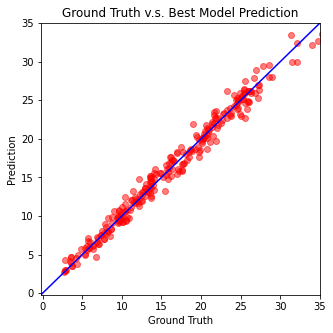

In [21]:
del model
model = torch.load(config['save_path']).to(device)
plot_pred(dev_dataloader, model, device)

# 测试

In [22]:
# 保存预测结果
def save_pred(preds, file):
    print('Saving result to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(test_dataloader, model, device)
save_pred(preds, 'covid.pred.csv')

Saving result to covid.pred.csv


# 结果

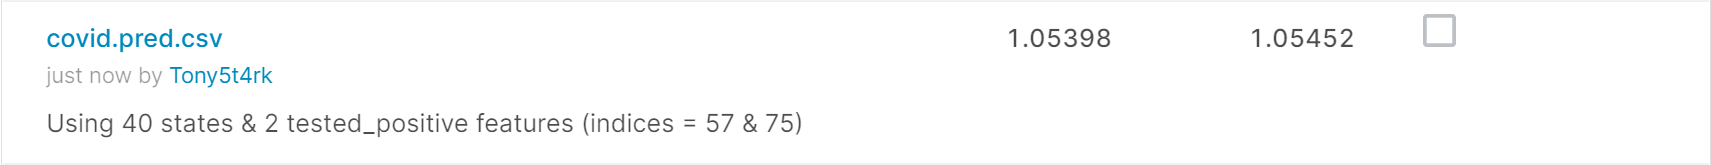